In [14]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import yfinance as yf


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from src.data_loader import load_stock_data
from src.feature_engineering import add_technical_indicators

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

In [15]:

ticker = yf.Ticker("AAPL")
df = ticker.history(period="20y") 
df_with_indicators = add_technical_indicators(df)

print(f" Базові дані: {df_with_indicators.shape}")
print(f" Колонки: {list(df_with_indicators.columns)}")

def add_advanced_features(df):
    df = df.copy()

    for lag in [1, 2, 3, 5, 10]:
        df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
        df[f'Volume_Lag_{lag}'] = df['Volume'].shift(lag)

    for period in [5, 10, 20]:
        df[f'Volatility_{period}'] = df['Close'].rolling(period).std()
        df[f'Return_{period}'] = df['Close'].pct_change(period)

    for period in [5, 10, 20]:
        df[f'Momentum_{period}'] = df['Close'] / df['Close'].shift(period) - 1
        df[f'ROC_{period}'] = ((df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period)) * 100

    if 'SMA_20' in df.columns:
        df['Close_vs_SMA20'] = (df['Close'] - df['SMA_20']) / df['SMA_20']
    if 'SMA_50' in df.columns:
        df['Close_vs_SMA50'] = (df['Close'] - df['SMA_50']) / df['SMA_50']

    if 'BB_Lower_20' in df.columns and 'BB_Upper_20' in df.columns:
        df['BB_Position'] = (df['Close'] - df['BB_Lower_20']) / (df['BB_Upper_20'] - df['BB_Lower_20'])

    df['Volume_Ratio'] = df['Volume'] / df['Volume'].rolling(20).mean()

    return df

df_advanced = add_advanced_features(df_with_indicators)

 Базові дані: (5032, 139)
 Колонки: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'SMA_200', 'EMA_10', 'EMA_20', 'EMA_50', 'SMA_20_50_Cross', 'RSI_14', 'RSI_21', 'Stoch_K', 'Stoch_D', 'Williams_R', 'ROC_5', 'ROC_10', 'ROC_20', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'ADX', 'Plus_DI', 'Minus_DI', 'PSAR', 'BB_Upper_10', 'BB_Lower_10', 'BB_Middle_10', 'BB_Width_10', 'BB_Position_10', 'BB_Upper_20', 'BB_Lower_20', 'BB_Middle_20', 'BB_Width_20', 'BB_Position_20', 'BB_Upper_50', 'BB_Lower_50', 'BB_Middle_50', 'BB_Width_50', 'BB_Position_50', 'ATR_14', 'ATR_21', 'HV_10', 'HV_20', 'HV_30', 'Volume_SMA_10', 'Volume_Ratio_10', 'Volume_SMA_20', 'Volume_Ratio_20', 'Volume_SMA_50', 'Volume_Ratio_50', 'OBV', 'VPT', 'AD_Line', 'MFI', 'Price_Change_1', 'Price_Change_Abs_1', 'Price_Change_2', 'Price_Change_Abs_2', 'Price_Change_3', 'Price_Change_Abs_3', 'Price_Change_5', 'Price_Chang

In [16]:
df_advanced['Next_Close'] = df_advanced['Close'].shift(-1)
df_advanced['Direction'] = (df_advanced['Next_Close'] > df_advanced['Close']).astype(int)

df_clean = df_advanced[:-1].dropna()

print(f" Розмір даних після очищення: {df_clean.shape}")
print(f" Розподіл напрямків:")
print(df_clean['Direction'].value_counts())
print(f" Відсоток UP днів: {df_clean['Direction'].mean()*100:.1f}%")

feature_cols = [
    'SMA_5', 'SMA_20', 'SMA_50', 'RSI_14', 'MACD', 'MACD_Signal',
    'BB_Upper_20', 'BB_Lower_20', 'BB_Position',
    'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_5',
    'Volume_Lag_1', 'Volume_Lag_2', 'Volume_Lag_3',
    'Volatility_5', 'Volatility_10', 'Volatility_20',
    'Return_5', 'Return_10', 'Return_20',
    'Momentum_5', 'Momentum_10', 'Momentum_20',
    'Close_vs_SMA20', 'Close_vs_SMA50', 'Volume_Ratio'
]

available_features = [col for col in feature_cols if col in df_clean.columns]
missing_features = [col for col in feature_cols if col not in df_clean.columns]

print(f" Using {len(available_features)} з {len(feature_cols)} features")
if missing_features:
    print(f"️ Відсутні featuresи: {missing_features}")

print(f" Доступні featuresи: {available_features}")

X = df_clean[available_features]
y = df_clean['Direction']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f" Тренувальна вибірка: {X_train.shape[0]} ")
print(f" Тестова вибірка: {X_test.shape[0]} ")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

 Розмір даних після очищення: (4832, 151)
 Розподіл напрямків:
Direction
1    2560
0    2272
Name: count, dtype: int64
 Відсоток UP днів: 53.0%
 Using 28 з 28 features
 Доступні featuresи: ['SMA_5', 'SMA_20', 'SMA_50', 'RSI_14', 'MACD', 'MACD_Signal', 'BB_Upper_20', 'BB_Lower_20', 'BB_Position', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_5', 'Volume_Lag_1', 'Volume_Lag_2', 'Volume_Lag_3', 'Volatility_5', 'Volatility_10', 'Volatility_20', 'Return_5', 'Return_10', 'Return_20', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'Close_vs_SMA20', 'Close_vs_SMA50', 'Volume_Ratio']
 Тренувальна вибірка: 3865 
 Тестова вибірка: 967 


In [17]:
models = {}
results = {}

start_time = time.time()

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)
rf_time = time.time() - start_time

rf_pred = rf.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)

models['Random Forest'] = rf
results['Random Forest'] = {
    'accuracy': rf_accuracy,
    'training_time': rf_time,
    'predictions': rf_pred
}

print(f"    Accuracy: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"   ⏱️ Training time: {rf_time:.2f} seconds")

start_time = time.time()

gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
gb.fit(X_train_scaled, y_train)
gb_time = time.time() - start_time

gb_pred = gb.predict(X_test_scaled)
gb_accuracy = accuracy_score(y_test, gb_pred)

models['Gradient Boosting'] = gb
results['Gradient Boosting'] = {
    'accuracy': gb_accuracy,
    'training_time': gb_time,
    'predictions': gb_pred
}

print(f"    Accuracy: {gb_accuracy:.4f} ({gb_accuracy*100:.2f}%)")
print(f"   ⏱️ Training time: {gb_time:.2f} seconds")

start_time = time.time()

voting = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)),
        ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42))
    ],
    voting='soft'
)
voting.fit(X_train_scaled, y_train)
voting_time = time.time() - start_time

voting_pred = voting.predict(X_test_scaled)
voting_accuracy = accuracy_score(y_test, voting_pred)

models['Voting Ensemble'] = voting
results['Voting Ensemble'] = {
    'accuracy': voting_accuracy,
    'training_time': voting_time,
    'predictions': voting_pred
}

print(f"    Accuracy: {voting_accuracy:.4f} ({voting_accuracy*100:.2f}%)")
print(f"   ⏱️ Training time: {voting_time:.2f} seconds")

for model_name, result in results.items():
    print(f"{model_name:20} | Accuracy: {result['accuracy']:7.4f} | Час: {result['training_time']:6.2f}с")

best_model = max(results.keys(), key=lambda x: results[x]['accuracy'])
print(f"\n Найкраща модель: {best_model} ({results[best_model]['accuracy']*100:.2f}%)")

    Accuracy: 0.5181 (51.81%)
   ⏱️ Training time: 0.12 seconds
    Accuracy: 0.5036 (50.36%)
   ⏱️ Training time: 3.81 seconds
    Accuracy: 0.5067 (50.67%)
   ⏱️ Training time: 3.93 seconds
Random Forest        | Accuracy:  0.5181 | Час:   0.12с
Gradient Boosting    | Accuracy:  0.5036 | Час:   3.81с
Voting Ensemble      | Accuracy:  0.5067 | Час:   3.93с

 Найкраща модель: Random Forest (51.81%)


/Users/urdzik/Developer/SET/Intro to deep learning/Capstone Project/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/urdzik/Developer/SET/Intro to deep learning/Capstone Project/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/urdzik/Developer/SET/Intro to deep learning/Capstone Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/urdzik/Developer/SET/Intro to deep learning/Capstone Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


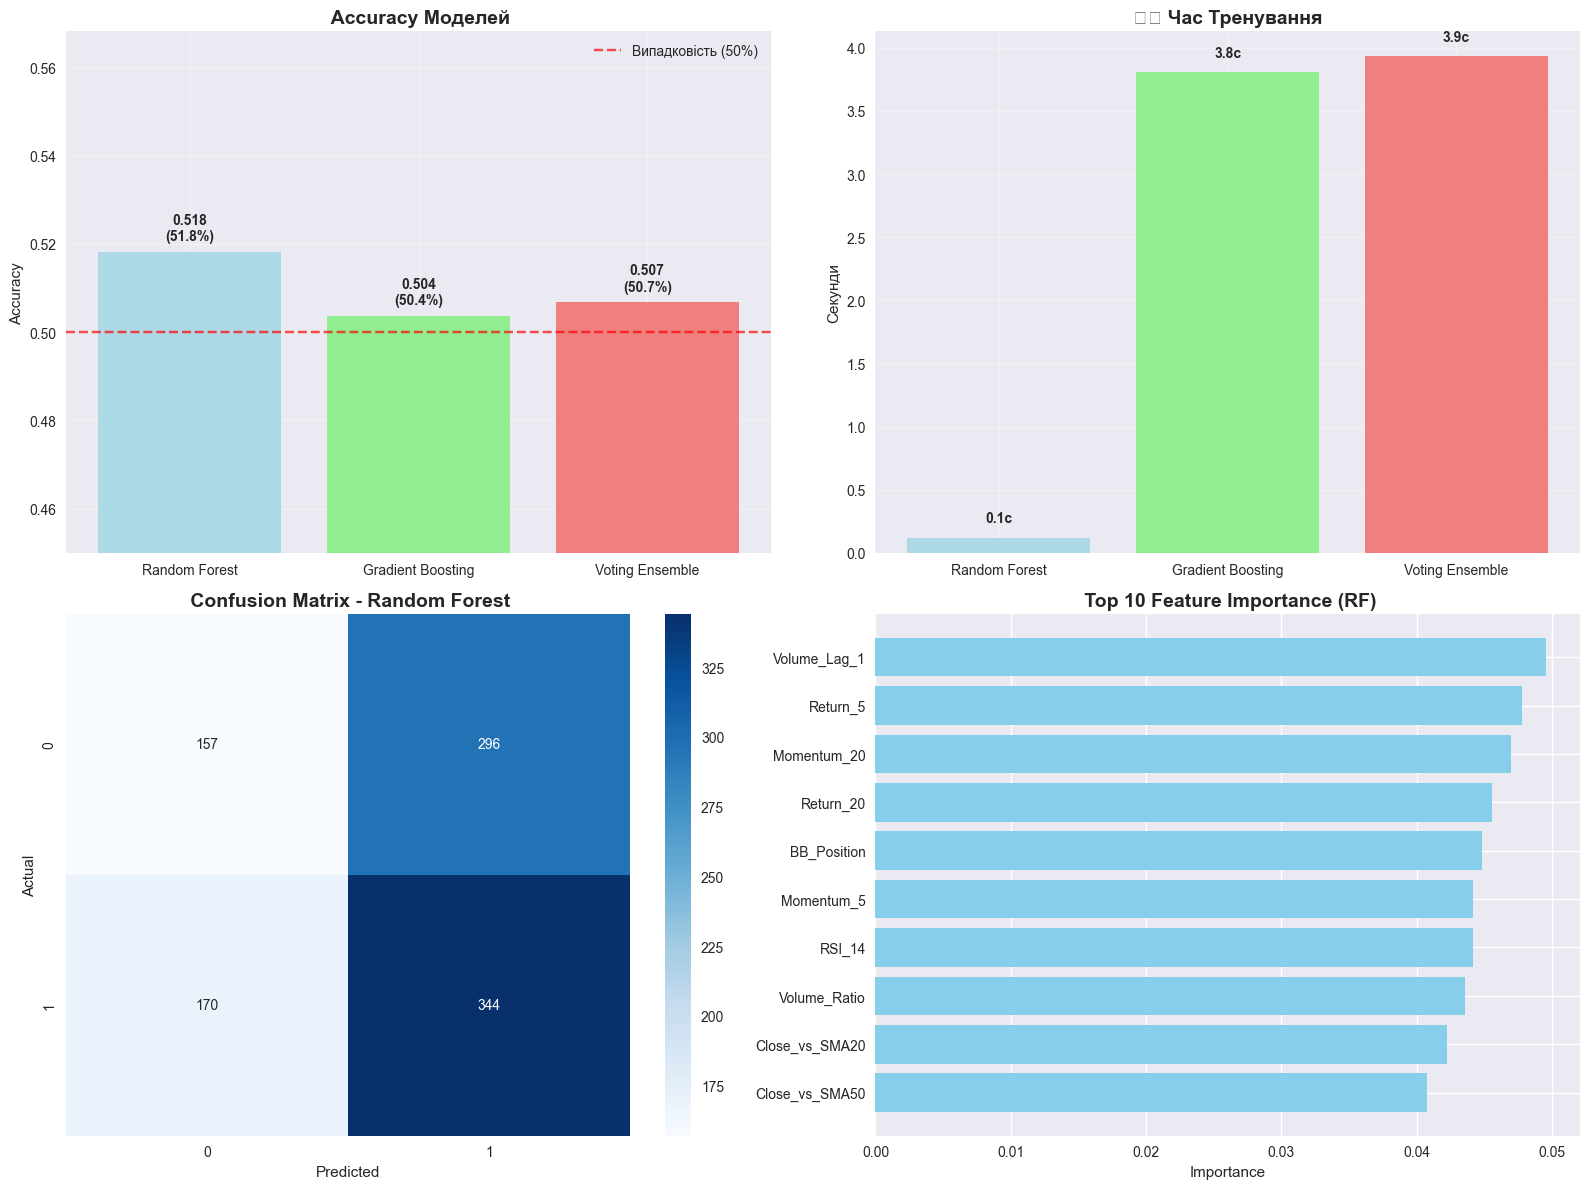

              precision    recall  f1-score   support

        DOWN       0.48      0.35      0.40       453
          UP       0.54      0.67      0.60       514

    accuracy                           0.52       967
   macro avg       0.51      0.51      0.50       967
weighted avg       0.51      0.52      0.51       967


 Додаткові метрики:
   • Accuracy UP днів: 66.9%
   • Accuracy DOWN днів: 34.7%
   • Загальна точність: 51.8%


In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
times = [results[name]['training_time'] for name in model_names]

bars = axes[0, 0].bar(model_names, accuracies, color=['lightblue', 'lightgreen', 'lightcoral'])
axes[0, 0].set_title(' Accuracy Моделей', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim(0.45, max(accuracies) + 0.05)
axes[0, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Випадковість (50%)')

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.002,
                   f'{acc:.3f}\n({acc*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

bars2 = axes[0, 1].bar(model_names, times, color=['lightblue', 'lightgreen', 'lightcoral'])
axes[0, 1].set_title('⏱️ Час Тренування', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Секунди')

for bar, time_val in zip(bars2, times):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{time_val:.1f}с', ha='center', va='bottom', fontweight='bold')

axes[0, 1].grid(True, alpha=0.3)

best_predictions = results[best_model]['predictions']
cm = confusion_matrix(y_test, best_predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title(f' Confusion Matrix - {best_model}', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

if 'Random Forest' in models:
    rf_model = models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': available_features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=True).tail(10)

    axes[1, 1].barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
    axes[1, 1].set_title(' Top 10 Feature Importance (RF)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Importance')

plt.tight_layout()
plt.show()


best_pred = results[best_model]['predictions']
print(classification_report(y_test, best_pred, target_names=['DOWN', 'UP']))

print(f"\n Додаткові метрики:")
print(f"   • Accuracy UP днів: {sum((y_test == 1) & (best_pred == 1)) / sum(y_test == 1)*100:.1f}%")
print(f"   • Accuracy DOWN днів: {sum((y_test == 0) & (best_pred == 0)) / sum(y_test == 0)*100:.1f}%")
print(f"   • Загальна точність: {accuracy_score(y_test, best_pred)*100:.1f}%")

